## Dataloader

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

    return dataloaders

data_dir = 'Dataset_2/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)

In [7]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Models

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

## Training

In [4]:
from tqdm import tqdm
import torch
import os

def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_dir):
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct_train += (predicted == labels.float()).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))
                correct_val += (predicted == labels.float()).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))

    print('Training complete.')

## ResNet50

In [6]:
model = load_resnet50(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/resnet50_2')

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:34<00:00, 13.00it/s]


Epoch [1/10] - Train Loss: 0.0976, Train Acc: 96.11%, Val Loss: 0.1053, Val Acc: 95.81%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:34<00:00, 13.05it/s]


Epoch [2/10] - Train Loss: 0.0616, Train Acc: 97.52%, Val Loss: 0.1272, Val Acc: 94.79%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:35<00:00, 12.96it/s]


Epoch [3/10] - Train Loss: 0.0515, Train Acc: 97.94%, Val Loss: 0.0794, Val Acc: 96.90%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:42<00:00, 12.03it/s]


Epoch [4/10] - Train Loss: 0.0427, Train Acc: 98.27%, Val Loss: 0.0989, Val Acc: 96.27%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:42<00:00, 12.07it/s]


Epoch [5/10] - Train Loss: 0.0379, Train Acc: 98.43%, Val Loss: 0.0770, Val Acc: 97.14%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:40<00:00, 12.24it/s]


Epoch [6/10] - Train Loss: 0.0323, Train Acc: 98.68%, Val Loss: 0.0776, Val Acc: 97.26%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:41<00:00, 12.10it/s]


Epoch [7/10] - Train Loss: 0.0286, Train Acc: 98.79%, Val Loss: 0.0979, Val Acc: 96.65%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:41<00:00, 12.14it/s]


Epoch [8/10] - Train Loss: 0.0258, Train Acc: 98.96%, Val Loss: 0.0702, Val Acc: 97.64%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:41<00:00, 12.19it/s]


Epoch [9/10] - Train Loss: 0.0228, Train Acc: 99.07%, Val Loss: 0.0632, Val Acc: 97.98%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████| 1233/1233 [01:40<00:00, 12.24it/s]

Epoch [10/10] - Train Loss: 0.0208, Train Acc: 99.14%, Val Loss: 0.0912, Val Acc: 97.22%
Training complete.


## EfficientNet

In [7]:
model = load_efficientnet_b0(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/efficientnet_2')

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 20.95it/s]


Epoch [1/10] - Train Loss: 0.0726, Train Acc: 97.20%, Val Loss: 0.0914, Val Acc: 96.53%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 20.96it/s]


Epoch [2/10] - Train Loss: 0.0473, Train Acc: 98.17%, Val Loss: 0.0807, Val Acc: 96.98%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 20.97it/s]


Epoch [3/10] - Train Loss: 0.0387, Train Acc: 98.51%, Val Loss: 0.0772, Val Acc: 97.39%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 21.01it/s]


Epoch [4/10] - Train Loss: 0.0342, Train Acc: 98.64%, Val Loss: 0.0692, Val Acc: 97.62%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 21.10it/s]


Epoch [5/10] - Train Loss: 0.0300, Train Acc: 98.82%, Val Loss: 0.0675, Val Acc: 97.74%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:59<00:00, 20.77it/s]


Epoch [6/10] - Train Loss: 0.0272, Train Acc: 98.91%, Val Loss: 0.0557, Val Acc: 97.94%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [01:00<00:00, 20.28it/s]


Epoch [7/10] - Train Loss: 0.0240, Train Acc: 99.03%, Val Loss: 0.0579, Val Acc: 98.03%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 21.03it/s]


Epoch [8/10] - Train Loss: 0.0220, Train Acc: 99.11%, Val Loss: 0.0545, Val Acc: 98.22%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████| 1233/1233 [00:59<00:00, 20.82it/s]


Epoch [9/10] - Train Loss: 0.0199, Train Acc: 99.17%, Val Loss: 0.0573, Val Acc: 98.14%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████| 1233/1233 [00:58<00:00, 21.20it/s]

Epoch [10/10] - Train Loss: 0.0187, Train Acc: 99.26%, Val Loss: 0.0558, Val Acc: 98.13%
Training complete.


## Testing

In [10]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images/TEST_2_10ep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_test_dataloader(data_dir, batch_size, num_workers=4):
    # Define transformations for the test dataset
    data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create the test dataset
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transform)

    # Print the class-to-index mapping
    print("Class to index mapping:", test_dataset.class_to_idx)
    
    # Create the test dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

data_dir = 'Dataset_2/'
batch_size = 32
test_loader = create_test_dataloader(data_dir, batch_size)

Class to index mapping: {'Fake': 0, 'Real': 1}


In [12]:
from torch import nn
from torchvision import models
from tqdm import tqdm

# Function to load the model
def load_model(model_class, checkpoint_path, num_classes):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

In [13]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

def evaluate_model(model_name, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.float()).sum().item()
            total += labels.size(0)

            # Collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Generate classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['FAKE', 'REAL']))

    print("\nConfusion Matrix:")
    skplt.metrics.plot_confusion_matrix(all_labels, all_predictions)
    save_fig(f"{model_name}_CM")

In [14]:
# List of model loading functions
model_functions = [
    load_resnet50,
    load_efficientnet_b0,
]

checkpoint_paths = [
    'Checkpoints/resnet50_2/model_epoch_9.pth',
    'Checkpoints/efficientnet_2/model_epoch_8.pth',
]

model_names = [
    'resnet50', 'efficientnet'
]

Checkpoints/resnet50_2/model_epoch_9.pth


Testing:  99%|██████████████████████████████████████████████████████████████████████▌| 339/341 [00:34<00:00, 13.58it/s]C:\Users\User\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Testing: 100%|███████████████████████████████████████████████████████████████████████| 341/341 [00:35<00:00,  9.56it/s]


Test Loss: 0.3632, Test Accuracy: 91.32%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.88      0.96      0.92      5492
        REAL       0.96      0.86      0.91      5413

    accuracy                           0.91     10905
   macro avg       0.92      0.91      0.91     10905
weighted avg       0.92      0.91      0.91     10905


Confusion Matrix:
Checkpoints/efficientnet_2/model_epoch_8.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████| 341/341 [00:23<00:00, 14.40it/s]


Test Loss: 0.6828, Test Accuracy: 90.44%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.86      0.97      0.91      5492
        REAL       0.96      0.84      0.90      5413

    accuracy                           0.90     10905
   macro avg       0.91      0.90      0.90     10905
weighted avg       0.91      0.90      0.90     10905


Confusion Matrix:


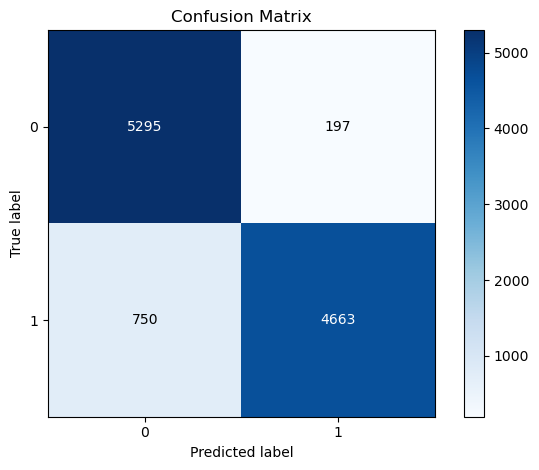

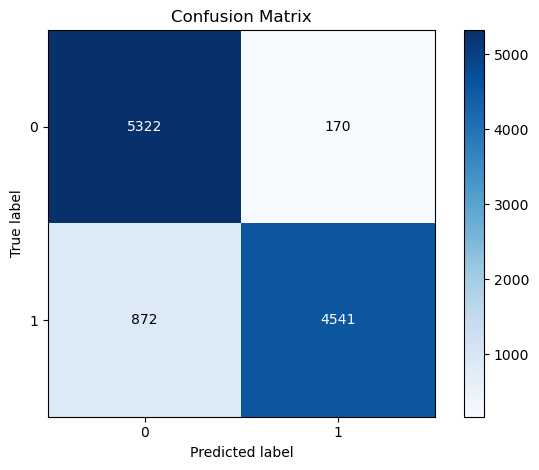

In [15]:
num_classes = 1
loss_fn = nn.BCEWithLogitsLoss()

for get_model, checkpoint_path, model_name in zip(model_functions, checkpoint_paths, model_names):
    # Load the model using the function
    loaded_model = load_model(get_model, checkpoint_path, num_classes)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(model_name, loaded_model, test_loader, loss_fn)